In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns

from modules import *
InputData.load_data(demand_column = "ANSPRACHE")

In [ ]:
# TODO: evaluieren der korrekten window positionen unter zero indexing, was sind die mindest dinger für die grid search windows, input dataen vollenden (z.B. NAs), die iid bootstraps implementieren

# FIXME: 

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#kann ich meine Ergebnisse eindeutiger machen, wenn ich mehr als 100 Testartikel nehme?
# wo würde ich die cv der samples untersuchen?
# Evaluate influence of sample size on calculcation time
# Wie kann ich unterscheiden, ob der Fehler vom Model oder von den Twins kommt

# Window Size Analysis

[  2.  10.  18.  26.  34.  42.  50.  58.  66.  74.  82.  90.  98. 106.
 114. 122. 130. 138. 146. 154. 162. 170. 178. 186. 194. 202. 210. 218.
 226. 234. 242. 250. 258. 266. 274. 282. 290. 298. 305. 305.]


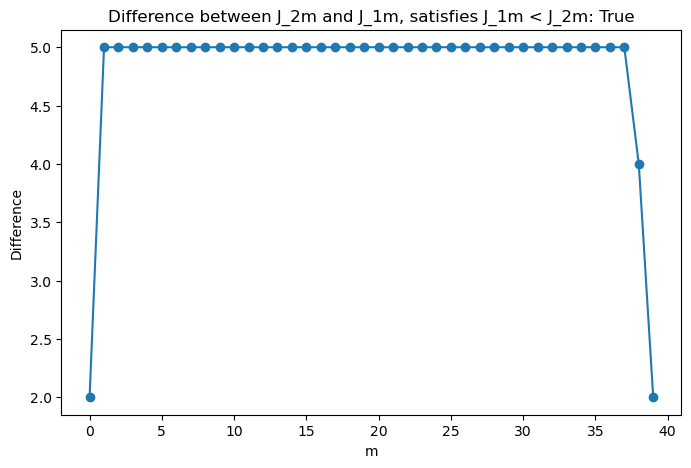

In [ ]:
#sind meine windows centered oder asymmetrisch? -> den zenterpunkt +0.5 setzen
#window size dürfen nur gerade zahlen sein, sonst sind grenzen dezimalzahlen
#dadurch, dass der ub nicht inclusive ist, sind die intervalle nicht symmetrisch um den Index m*b
#was wäre eine Lösung? (abwägung zwischen symmetrischem, ungeraden intervall und asymmetrischem, geraden intervall)
#window size 1 hat die beste performance, dass müssen wir also eigentlich berücksichtigen
#-> wie verhalten sich die intervallgrenzen bei window size 1? mit den decimalzahlengrenzen
#-> vielleicht is es deshalb nicht viel besser als der standard bootstrap
N = 313
b = 8
w = 4
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2-1, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Parameter Tuning

In [6]:
GridEvaluation.run(list(InputData.TestData.keys())) #3min auf dem Mac

Batch processing and streaming:   0%|          | 0/20 [00:00<?, ?it/s]

In [66]:
df_grid_results = pd.read_csv("results/grid_results.csv")
df_grid_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("MAPE").reset_index()[["WINDOW_SIZE", "BLOCK_SIZE", "MAPE" ]].head(10) #median, bc distribution is skewed
# auf Shortcomings des MAPE hinweisen in der Arbeit!
# alternativ den Mean Absolute Scaled Error und Symmetric Mean Absolute Percentage Error testen

,WINDOW_SIZE,BLOCK_SIZE,MAPE
0,17,1,35.739595
1,13,1,35.752526
2,25,1,35.769792
3,1,1,35.793659
4,21,1,35.801447
5,9,1,35.882187
6,33,1,35.882527
7,5,1,35.946035
8,0,1,36.065345
9,29,1,36.073566


In [58]:
best_params = (1, 1)

results = []

for key in InputData.TestData.keys():
    result_entry = {
        "Key": key,
        "LBB_MAPE": Metrics.mape(InputData.TestData[key], Resampling.lb_bootstrap(InputData.TwinData[key], *best_params)),
        "LBB_MPE": Metrics.mpe(InputData.TestData[key], Resampling.lb_bootstrap(InputData.TwinData[key], *best_params)),
        "IDD_MAPE": Metrics.mape(InputData.TestData[key], Resampling.iid_bootstrap(InputData.TwinData[key]))
    }
    results.append(result_entry)

df_results = pd.DataFrame(results)

# Best Parameter Configuration vs. Benchmark

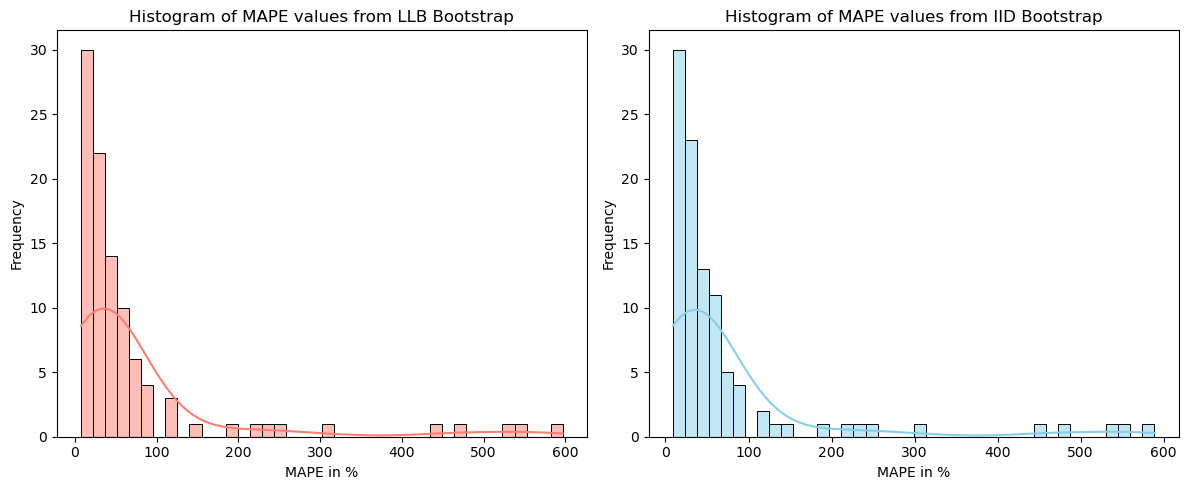

In [70]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_results["LBB_MAPE"], bins=40, kde=True, color='salmon')
plt.xlabel("MAPE in %")
plt.ylabel("Frequency")
plt.title("Histogram of MAPE values from LLB Bootstrap")

plt.subplot(1, 2, 2)
sns.histplot(df_results["IDD_MAPE"], bins=40, kde=True, color="skyblue")
plt.xlabel("MAPE in %")
plt.ylabel("Frequency")
plt.title("Histogram of MAPE values from IID Bootstrap")

plt.tight_layout()
plt.show()

# Error Analysis
- Model bias distribution
- Identifying and analysing outlier items

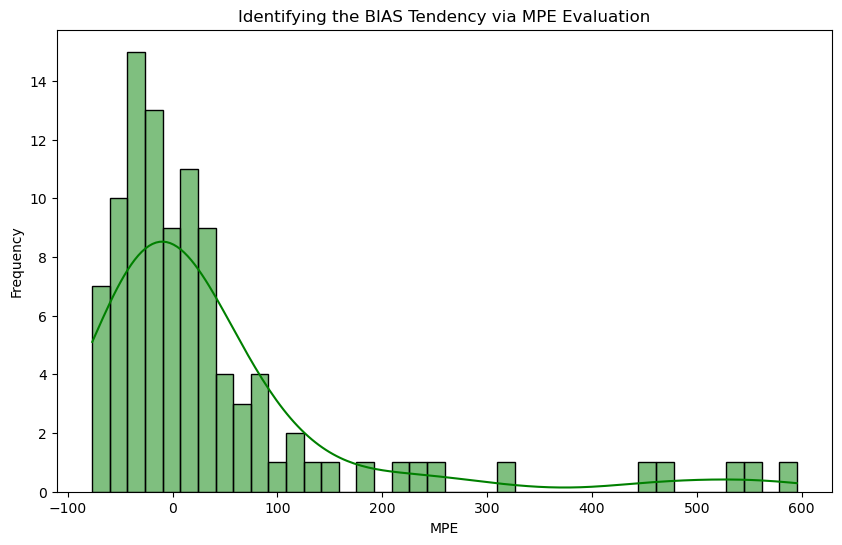

In [67]:
#note: mape is not symmetric!
plt.figure(figsize=(10, 6))
sns.histplot(df_results["LBB_MPE"], bins=40, kde=True, color="green")
plt.xlabel("MPE")
plt.ylabel("Frequency")
plt.title("Identifying the BIAS Tendency via MPE Evaluation")
plt.show()

In [ ]:
df_results.groupby("Key").median().sort_values("LBB_MPE", ascending=True).reset_index()[["Key", "IDD_MAPE", "LBB_MAPE", "LBB_MPE"]].head(10)
#863526628 twinws viel mehr Ansprache als test
#1107699346 twins viel mehr Ansprache als test
#848151556 twins viel mehr Ansprache als test
#1574713555 twins viel mehr Ansprache als test
#824008632 twins viel mehr Ansprache als test
#803656013 twins viel mehr Ansprache als test
#1088112515 twins viel mehr Ansprache als test
#829628090 twins viel mehr Ansprache als test
#... immer das gleiche

#848764870 hier passen die Saisonkurven nicht
#1066797131 hier passen die Saisonkurven nicht

#ansonsten sind logischerweise auch die twins mal geringer

,Key,IDD_MAPE,LBB_MAPE,LBB_MPE
0,1061289615,76.494590,76.547540,-76.540604
1,842058910,71.301027,71.449319,-71.442318
2,1064614421,67.793997,67.596649,-67.622723
3,943969594,66.223287,66.197234,-66.214770
4,848764870,65.241874,65.320796,-65.268139
5,832962701,64.534764,64.614267,-64.468766
6,837663879,63.924594,63.861720,-63.848716
7,1064646595,59.496905,59.677903,-59.532945
8,1066797131,57.697724,57.665208,-57.698775
9,837668025,54.169927,54.312958,-54.139800


# Experiments

- Apply smoothing function on input time series
- Ansprache Marketing Imputed
- Influence of number of twins
- Change of observation period, change of product group
- Einfluss von NAs auf den Fehler
- Einfluss von Soldout auf den Fehler


# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

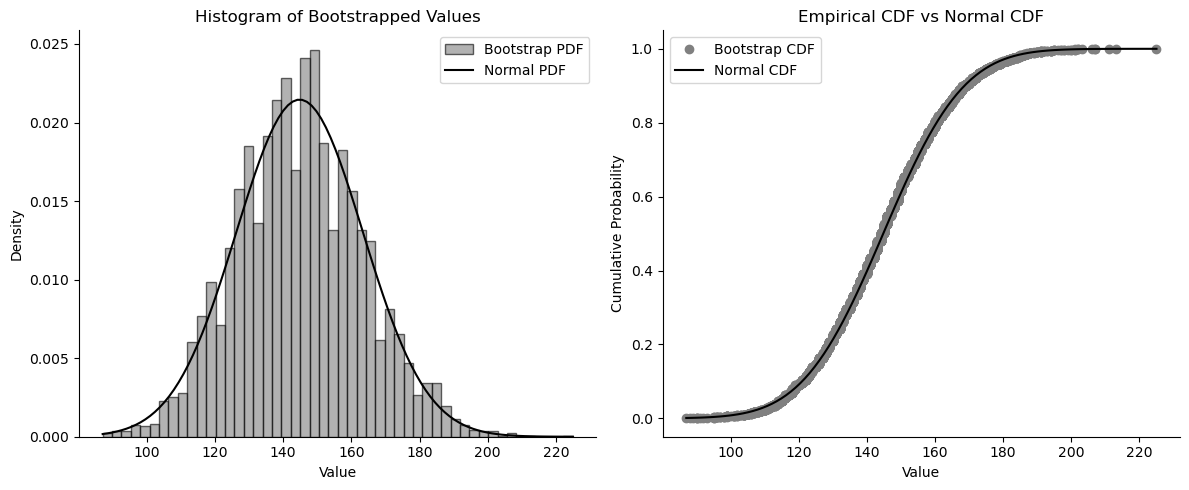

In [16]:
samples = Resampling.lb_bootstrap(InputData.TestData[804245827], 14, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(samples, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(samples), max(samples), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(samples)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [17]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [18]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [19]:
norm_samples = np.random.normal(50, 5, 100000).astype(int)
_, p_value = stats.normaltest(norm_samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

0.5957888457484879
Fail to reject the null hypothesis: The data appears to be normally distributed.


In [20]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

NameError: name 'results_simple' is not defined